# Apply RNA2seg on spatial data 

This notebook presents the workflow for applying RNA2Seg on Zarr-saved dataset. The process is structured into five main steps:

- **1-Create training patches** - Extract patches of a reasonable size to process efficiently (saved in the Zarr file). 
- **2-Initialize an RNA2segDataset**
- **3-Initialize a model RNA2Seg**
- **4-Run segmentation**: RNA2Seg is applied to the dataset to generate cell segmentations, which are then saved in a Zarr format.
- **5-Visualize segmentation**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import spatialdata as sd
from pathlib import Path

## Step 1: Create patches from Zarr files

In this step, the dataset (image + transcripts) is divided into patches of size `patch_width × patch_width` with an overlap of `patch_overlap`. This allows processing images of a manageable size while preserving spatial continuity.  

**Process** 
- The dataset, stored in Zarr format, is loaded.  
- Patches coordinates are saved as a `Shape` in the zarr: `sopa_patches_rna2seg_[patch_width]_[patch_overlap]`. 
- A `.rna2seg` directory is created to store the transcript data corresponding to each patch.  
- The transcript information for each patch is saved in CSV format for further processing.  


In [3]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import spatialdata as sd
from pathlib import Path

from rna2seg.dataset_zarr.patches import create_patch_rna2seg


# MODIFY WITH YOUR PATH
merfish_zarr_path = "/media/tom/Transcend/open_merfish/test_spatial_data/from_cluster/test_mouse_ileum.zarr"

### load sdata and set path parameters 
sdata = sd.read_zarr(merfish_zarr_path)
image_key = "staining_z3"
points_key = "transcripts"
patch_width = 1200
patch_overlap = 150
min_transcripts_per_patch = 0
folder_patch_rna2seg = Path(merfish_zarr_path) / f".rna2seg_{patch_width}_{patch_overlap}"

### create patch in the sdata and precompute transcipt.csv for each patch with sopa
create_patch_rna2seg(sdata=sdata,
                    image_key=image_key,
                    points_key=points_key,
                    patch_width=patch_width,
                    patch_overlap=patch_overlap,
                    min_transcripts_per_patch=min_transcripts_per_patch,
                    folder_patch_rna2seg = folder_patch_rna2seg,
                    overwrite = True)
print(sdata)

[INFO] (sopa.patches._patches) Added 81 patche(s) to sdata['sopa_patches_rna2seg_1200_150']


[########################################] | 100% Completed | 18.12 ss
[########################################] | 100% Completed | 12.39 s
SpatialData object, with associated Zarr store: /media/tom/Transcend/open_merfish/test_spatial_data/from_cluster/test_mouse_ileum.zarr
├── Images
│     └── 'staining_z3': DataTree[cyx] (5, 9000, 9000), (5, 4500, 4500), (5, 2250, 2250), (5, 1125, 1125), (5, 562, 562)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
└── Shapes
      ├── 'Cellbound1': GeoDataFrame shape: (3258, 1) (2D shapes)
      ├── 'DAPI': GeoDataFrame shape: (2377, 1) (2D shapes)
      └── 'sopa_patches_rna2seg_1200_150': GeoDataFrame shape: (81, 3) (2D shapes)
with coordinate systems:
    ▸ 'microns', with elements:
        staining_z3 (Images), transcripts (Points), Cellbound1 (Shapes), DAPI (Shapes), sopa_patches_rna2seg_1200_150 (Shapes)


## Step 2: Initialize a RNA2segDataset

In [6]:
import albumentations as A
from rna2seg.dataset_zarr import RNA2segDataset

transform_resize  = A.Compose([
    A.Resize(width=512, height=512, interpolation=cv2.INTER_NEAREST),
])

dataset = RNA2segDataset(
    sdata=sdata,
    channels_dapi= ["DAPI"],
    channels_cellbound=["Cellbound1"],
    patch_width = patch_width,
    patch_overlap = patch_overlap,
    gene_column="gene",
    transform_resize = transform_resize,
    patch_dir=folder_patch_rna2seg
)

default shape_patch_key set to sopa_patches_rna2seg_1200_150
100%|██████████| 81/81 [00:00<00:00, 93.67it/s]
Number of valid patches: 64


## Step 3: Initialize a model RNA2seg

By default, the trained RNA2seg model is downloaded from Hugging Face. You can also specify `pretrained_model` to use your own RNA2seg model.

In [7]:
from rna2seg.models import RNA2seg


device = "cpu"


rna2seg = RNA2seg(
    device,
    net='unet',
    flow_threshold = 0.9,
    cellbound_flow_threshold = 0.4,
    pretrained_model = "default_pretrained"
)

No module named 'vmunet'
VMUnet not loaded
initiaisation of CPnet
Initiaisation of ChannelInvariantNet


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights from /home/tom/.cache/huggingface/hub/models--aliceblondel--RNA2seg/snapshots/26f9afe181ea58f808ecd9c0732c327936020b18/rna2seg.pt


## Step 4: Run segmentation 

We will run the segmentation on the entire dataset and save the results as a shape in the Zarr file.

In [8]:
from tqdm import tqdm
from rna2seg.utils import save_shapes2zarr

for i in tqdm(range(len(dataset))):
    input_dict = dataset[i]
    rna2seg.run(
        path_temp_save=folder_patch_rna2seg,
        input_dict=input_dict
    )

  2%|▏         | 1/64 [00:02<02:34,  2.45s/it]

47 cells detected


  3%|▎         | 2/64 [00:04<02:28,  2.39s/it]

45 cells detected


  5%|▍         | 3/64 [00:06<02:08,  2.11s/it]

28 cells detected


  6%|▋         | 4/64 [00:10<02:45,  2.76s/it]

90 cells detected


  8%|▊         | 5/64 [00:13<02:51,  2.91s/it]

92 cells detected


  9%|▉         | 6/64 [00:16<02:48,  2.91s/it]

82 cells detected


 11%|█         | 7/64 [00:18<02:26,  2.57s/it]

40 cells detected


 12%|█▎        | 8/64 [00:19<02:06,  2.26s/it]

26 cells detected


 14%|█▍        | 9/64 [00:22<02:13,  2.43s/it]

76 cells detected


 16%|█▌        | 10/64 [00:26<02:26,  2.72s/it]

78 cells detected


 17%|█▋        | 11/64 [00:28<02:21,  2.68s/it]

68 cells detected


 19%|█▉        | 12/64 [00:33<02:46,  3.21s/it]

105 cells detected


 20%|██        | 13/64 [00:36<02:44,  3.22s/it]

113 cells detected


 22%|██▏       | 14/64 [00:38<02:30,  3.01s/it]

85 cells detected


 23%|██▎       | 15/64 [00:41<02:20,  2.87s/it]

62 cells detected


 25%|██▌       | 16/64 [00:43<02:07,  2.65s/it]

46 cells detected


 27%|██▋       | 17/64 [00:46<02:14,  2.87s/it]

89 cells detected


 28%|██▊       | 18/64 [00:50<02:19,  3.04s/it]

72 cells detected


 30%|██▉       | 19/64 [00:52<02:07,  2.83s/it]

65 cells detected


 31%|███▏      | 20/64 [00:55<02:04,  2.84s/it]

71 cells detected


 33%|███▎      | 21/64 [00:57<01:51,  2.60s/it]

40 cells detected


 34%|███▍      | 22/64 [00:59<01:38,  2.34s/it]

25 cells detected


 36%|███▌      | 23/64 [01:01<01:29,  2.17s/it]

40 cells detected


 38%|███▊      | 24/64 [01:03<01:30,  2.27s/it]

56 cells detected


 39%|███▉      | 25/64 [01:08<02:00,  3.10s/it]

113 cells detected


 41%|████      | 26/64 [01:13<02:17,  3.62s/it]

102 cells detected


 42%|████▏     | 27/64 [01:16<02:09,  3.49s/it]

70 cells detected


 44%|████▍     | 28/64 [01:18<01:49,  3.04s/it]

37 cells detected


 45%|████▌     | 29/64 [01:20<01:33,  2.66s/it]

28 cells detected


 47%|████▋     | 30/64 [01:22<01:26,  2.54s/it]

41 cells detected


 48%|████▊     | 31/64 [01:24<01:19,  2.40s/it]

47 cells detected


 50%|█████     | 32/64 [01:29<01:41,  3.17s/it]

116 cells detected


 52%|█████▏    | 33/64 [01:32<01:39,  3.20s/it]

80 cells detected


 53%|█████▎    | 34/64 [01:35<01:28,  2.95s/it]

59 cells detected


 55%|█████▍    | 35/64 [01:37<01:20,  2.79s/it]

60 cells detected


 56%|█████▋    | 36/64 [01:40<01:15,  2.69s/it]

53 cells detected


 58%|█████▊    | 37/64 [01:43<01:14,  2.78s/it]

63 cells detected


 59%|█████▉    | 38/64 [01:44<01:02,  2.39s/it]

24 cells detected


 61%|██████    | 39/64 [01:46<00:54,  2.18s/it]

33 cells detected


 62%|██████▎   | 40/64 [01:51<01:14,  3.09s/it]

120 cells detected


 64%|██████▍   | 41/64 [01:53<01:01,  2.68s/it]

26 cells detected


 66%|██████▌   | 42/64 [01:54<00:49,  2.27s/it]

11 cells detected


 67%|██████▋   | 43/64 [01:56<00:47,  2.24s/it]

43 cells detected


 69%|██████▉   | 44/64 [01:58<00:42,  2.12s/it]

38 cells detected


 70%|███████   | 45/64 [02:00<00:40,  2.15s/it]

49 cells detected


 72%|███████▏  | 46/64 [02:03<00:40,  2.26s/it]

52 cells detected


 73%|███████▎  | 47/64 [02:05<00:39,  2.35s/it]

60 cells detected


 75%|███████▌  | 48/64 [02:07<00:35,  2.20s/it]

36 cells detected


 77%|███████▋  | 49/64 [02:09<00:30,  2.06s/it]

32 cells detected


 78%|███████▊  | 50/64 [02:11<00:28,  2.05s/it]

41 cells detected


 80%|███████▉  | 51/64 [02:13<00:26,  2.03s/it]

39 cells detected


 81%|████████▏ | 52/64 [02:15<00:24,  2.05s/it]

47 cells detected


 83%|████████▎ | 53/64 [02:17<00:23,  2.14s/it]

55 cells detected


 84%|████████▍ | 54/64 [02:22<00:28,  2.82s/it]

101 cells detected


 86%|████████▌ | 55/64 [02:26<00:29,  3.26s/it]

113 cells detected


 88%|████████▊ | 56/64 [02:28<00:22,  2.87s/it]

54 cells detected


 89%|████████▉ | 57/64 [02:31<00:19,  2.75s/it]

64 cells detected


 91%|█████████ | 58/64 [02:32<00:14,  2.49s/it]

53 cells detected


 92%|█████████▏| 59/64 [02:34<00:11,  2.23s/it]

37 cells detected


 94%|█████████▍| 60/64 [02:36<00:08,  2.06s/it]

39 cells detected


 95%|█████████▌| 61/64 [02:38<00:06,  2.07s/it]

52 cells detected


 97%|█████████▋| 62/64 [02:42<00:05,  2.74s/it]

97 cells detected


 98%|█████████▊| 63/64 [02:46<00:03,  3.11s/it]

109 cells detected


100%|██████████| 64/64 [02:50<00:00,  2.66s/it]

95 cells detected


### Add segmented cell in the spatialdata as shape
The segmentation of each patch are stored in ```folder_patch_rna2seg``` and can be add in the spataildata as follow : 

In [9]:
segmentation_shape_name = "test_rnas2eg"
save_shapes2zarr(dataset, segmentation_shape_name)

100%|██████████| 64/64 [00:00<00:00, 382.18it/s]


len(list_all_cells) 3930


Resolving conflicts: 100%|██████████| 5854/5854 [00:01<00:00, 4757.40it/s]


Added 3011 cell boundaries in sdata['test_rnas2eg']


## Step 5: Visualize segmentation

Now, we visualize the results.
The following code extracts and plots three images: RNA transcripts, a selected staining image, and the corresponding segmentation.
Ensure that `staining_id` is valid to avoid indexing errors, and check that `bounds` are within dataset limits.

Get RNA image ...
Get image ...
Get segmentation image ...
Get image ...


100%|██████████| 58/58 [00:00<00:00, 74.51it/s] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


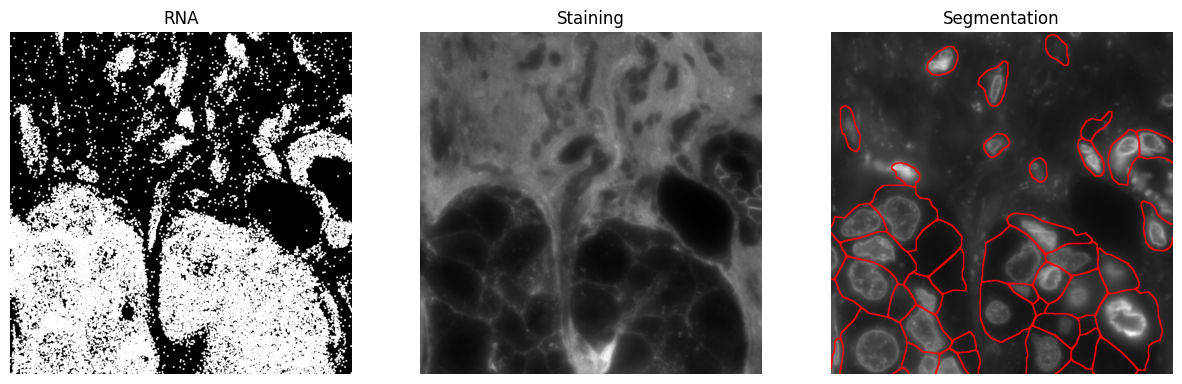

In [11]:
import matplotlib.pyplot as plt

# Parameters
key_segmentation="test_rnas2eg"
bounds = [2000, 3000, 3000, 4000,] # xmin, ymin, xmax, ymax
staining_id = 1 # Staining to plot

# Get images
rna = dataset.get_rna_img(bounds, key_transcripts=points_key,)
image = dataset.get_staining_img(bounds)
seg = dataset.get_segmentation_img(bounds, key_cell=key_segmentation)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rna)
axes[0].set_title("RNA")
axes[0].axis("off")

axes[1].imshow(image[staining_id], cmap="grey")
axes[1].set_title("Staining")
axes[1].axis("off")

axes[2].imshow(seg)
axes[2].set_title("Segmentation")
axes[2].axis("off")

plt.show()